# CDI example: ESRF logo

In [1]:
%matplotlib notebook
import os
import numpy as np
from numpy.fft import fftshift
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# This imports all necessary operators. GPU will be auto-selected
from pynx.cdi import *

## Get ESRF logo diffraction data
This dataset was recorded on at id10@ESRF, courtesy of Yuriy Chushkin

['mask', 'support', 'iobs']


<IPython.core.display.Javascript object>


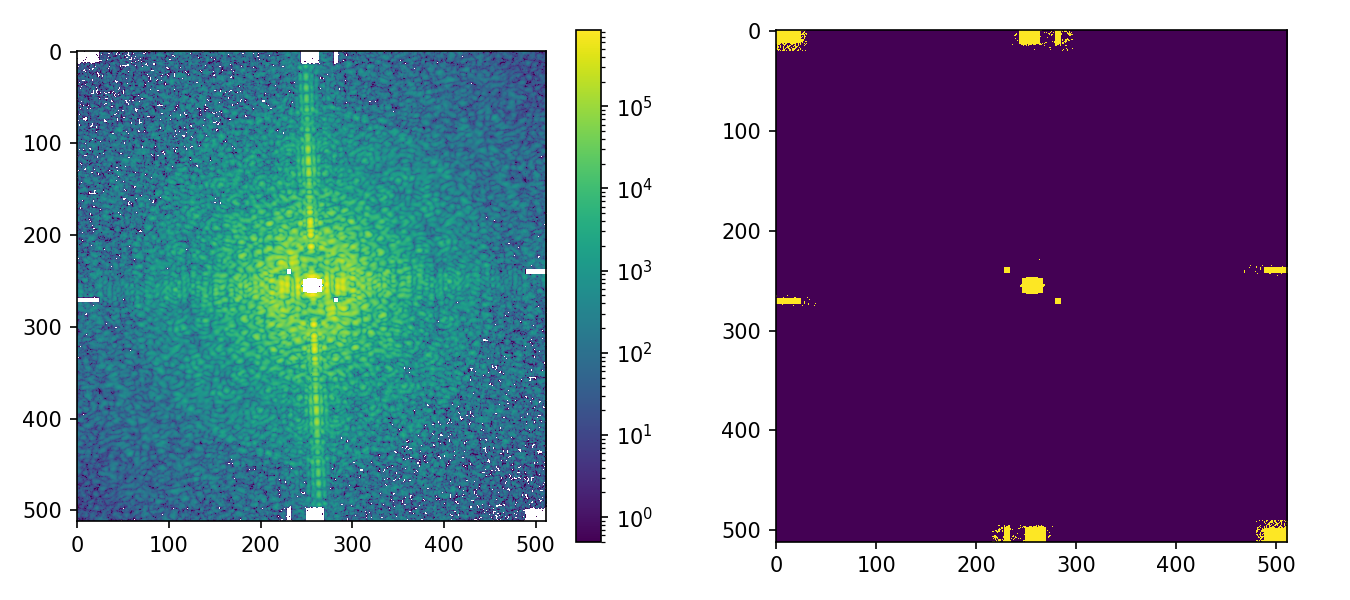

In [2]:
if not os.path.exists('logo5mu_20sec.npz'):
    os.system('curl -O https://zenodo.org/record/3451855/files/logo5mu_20sec.npz')

print(list(np.load('logo5mu_20sec.npz').keys()))
iobs = np.load('logo5mu_20sec.npz')['iobs']
mask = np.load('logo5mu_20sec.npz')['mask']
support = np.load('logo5mu_20sec.npz')['support']

plt.figure(1, figsize=(9,4))
plt.subplot(121)
plt.imshow(iobs, norm=LogNorm())
plt.colorbar()
plt.subplot(122)
plt.imshow(mask)
plt.tight_layout()

## Optimisation from the known support
First create the CDI object.

Set the initial object array using random values from the existing mask.

then optimise it using 4 series with 50 cycles of HIO and 20 of ER algorithms.

It converges very easily as the support is known.

<IPython.core.display.Javascript object>


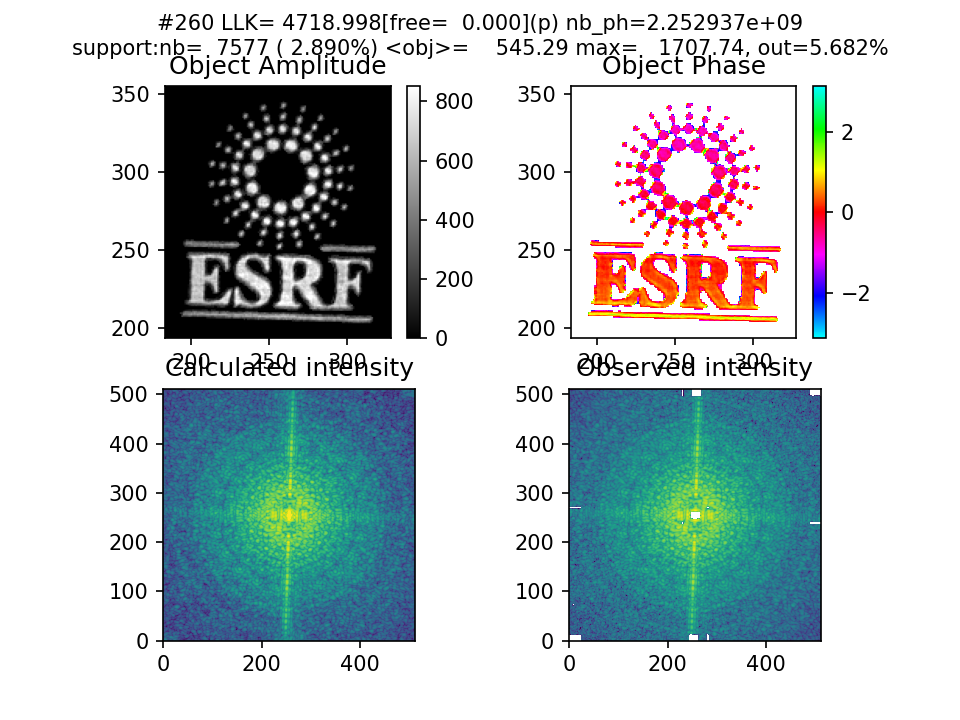

 HIO #  0 LLK= 4613.295[free=  0.000](p), nb photons=1.101198e+09, support:nb=  7577 ( 2.890%) <obj>=    381.23 max=   1707.42, out=15.593% dt/cycle=4.4058s 
 HIO # 20 LLK= 2413.191[free=  0.000](p), nb photons=1.890848e+09, support:nb=  7577 ( 2.890%) <obj>=    499.55 max=   1647.40, out=3.097% dt/cycle=0.0154s 
 HIO # 40 LLK= 4172.237[free=  0.000](p), nb photons=2.146526e+09, support:nb=  7577 ( 2.890%) <obj>=    532.25 max=   1668.80, out=5.347% dt/cycle=0.0003s 
  ER # 60 LLK=  67.490[free=  0.000](p), nb photons=1.656973e+09, support:nb=  7577 ( 2.890%) <obj>=    467.64 max=   1706.49, out=0.484% dt/cycle=0.0037s 
 HIO # 80 LLK= 1414.964[free=  0.000](p), nb photons=1.763803e+09, support:nb=  7577 ( 2.890%) <obj>=    482.48 max=   1671.53, out=2.781% dt/cycle=0.0195s 
 HIO #100 LLK= 3402.531[free=  0.000](p), nb photons=2.023631e+09, support:nb=  7577 ( 2.890%) <obj>=    516.79 max=   1657.91, out=5.011% dt/cycle=0.0004s 
  ER #120 LLK= 4767.501[free=  0.000](p), nb photons=2.269

In [3]:
################## Try first from the known support (too easy !) ################################################
cdi = CDI(fftshift(iobs), obj=None, support=fftshift(support), mask=fftshift(mask), wavelength=1e-10,
          pixel_size_detector=55e-6)

# Initial object
cdi = InitObjRandom(src="support", amin=0, amax=1, phirange=0) * cdi

# Initial scaling, required by mask
cdi = ScaleObj(method='F') * cdi

plt.figure()
cdi = (ER(show_cdi=20,calc_llk=20, fig_num=-1) ** 20 * HIO(show_cdi=50, calc_llk=20, fig_num=-1) ** 50) ** 4 * cdi

## Optimisation from a loose support
This will use the `SupportUpdate` operator in addition to ER and HIO.

We use positivity to facilitate convergence towards the solution. This example is difficult to get a good convergence because the object is divided in many small parts, and it is easy to get a wrong support

We can either start from:
* the real support expanded by a gaussian convolution.
* from a large circle.

The second choice is more difficult as the initial support is symmetrical, and there is an ambiguity between equivalent twin solutions. For this we perform a few cycles with a halved-support to break the symmetry

The critical parameter here is the threshold value. It is either possible to give it relative the the rms value of the density inside the support, the average or the maximum value (in this case, the threshold has to be set lower than for rms or average methods). In this example rms with threshold=0.28 works well (about half executions give a good result when starting from a smoothed initial support (much fewer for a large circle)).

If the resulting object does not look good, just re-execute the cell.

<IPython.core.display.Javascript object>


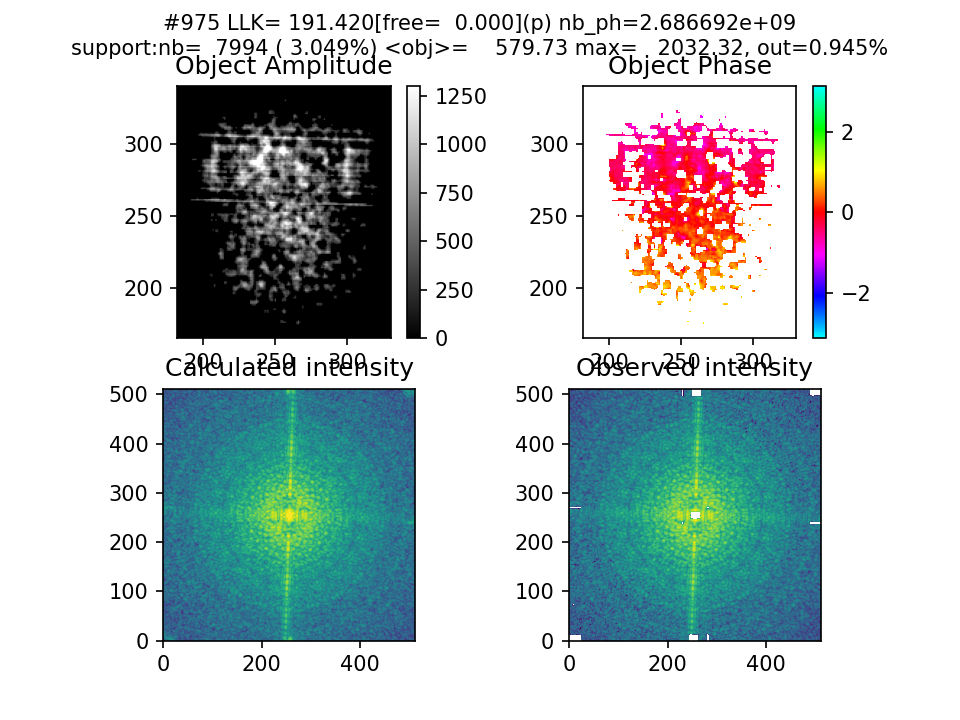

 HIO #300 LLK= 6769.820[free=  0.000](p), nb photons=2.218663e+09, support:nb= 14504 ( 5.533%) <obj>=    391.11 max=   1737.76, out=26.942% dt/cycle=0.0055s 
 HIO #325 LLK= 4520.894[free=  0.000](p), nb photons=2.846647e+09, support:nb= 15996 ( 6.102%) <obj>=    421.85 max=   2161.88, out=6.585% dt/cycle=0.0167s 
 HIO #350 LLK= 4544.086[free=  0.000](p), nb photons=2.998468e+09, support:nb= 15066 ( 5.747%) <obj>=    446.12 max=   2172.74, out=5.588% dt/cycle=0.0148s 
 HIO #375 LLK= 5101.502[free=  0.000](p), nb photons=3.107423e+09, support:nb= 14910 ( 5.688%) <obj>=    456.52 max=   2176.52, out=5.782% dt/cycle=0.0148s 
 HIO #400 LLK= 5341.136[free=  0.000](p), nb photons=3.229872e+09, support:nb= 14401 ( 5.494%) <obj>=    473.58 max=   2185.01, out=5.644% dt/cycle=0.0154s 
 HIO #425 LLK= 5785.357[free=  0.000](p), nb photons=3.312973e+09, support:nb= 14601 ( 5.570%) <obj>=    476.34 max=   2183.78, out=5.748% dt/cycle=0.0169s 
 HIO #450 LLK= 5928.857[free=  0.000](p), nb photons=3.39

In [6]:
if True:
    tmp = np.arange(-len(iobs)/2, len(iobs)/2)
    y, x = np.meshgrid(tmp, tmp, indexing='ij')
    r = np.sqrt(x**2+y**2)
    sup = r<70
else:
    sup = gaussian_filter(support.copy().astype(np.float32), 6) > 0.1

if False:
    plt.figure(figsize=(5,3))
    plt.imshow(sup, origin='lower')
    plt.title('Initial support')

cdi = CDI(fftshift(iobs), obj=None, support=fftshift(sup), mask=fftshift(mask), wavelength=1e-10,
          pixel_size_detector=55e-6)
# cdi.init_free_pixels()  # We will not use free log-likelihood in this example

# Initial object
cdi = InitObjRandom(src="support", amin=0, amax=1, phirange=0) * cdi

# Initial scaling, required by mask
cdi = ScaleObj(method='F') * cdi

# Support update operator
sup = SupportUpdate(threshold_relative=0.28, method='rms', smooth_width=(2,0.5,600),
                    force_shrink=False, post_expand=None)
#sup = SupportUpdate(threshold_relative=0.07, method='max', smooth_width=(2,0.5,600),
#                    force_shrink=False, post_expand=None)

# Start with HIO, detwin with a halved support, then HIO and ER,
# with a support update every 25 cycles
plt.figure()

cdi = (sup * HIO(calc_llk=0, positivity=True, fig_num=-1, show_cdi=25) ** 25)**4 * cdi

cdi = DetwinHIO(positivity=True, detwin_axis=0)**20 * cdi

cdi = (sup * HIO(calc_llk=25, positivity=True, fig_num=-1, show_cdi=25) ** 25)**20 * cdi

cdi = (sup * ER(calc_llk=25, positivity=True, fig_num=-1, show_cdi=25) ** 25)**8 * cdi